# library packages

In [ ]:
library(tidyverse)
library(readxl)
library(writexl)
library(pheatmap)
library(corrplot)
library(ggpubr)
library(Matrix)
library(paletteer)

library(Seurat)
library(SeuratData)
library(SeuratWrappers)

library(patchwork)
library(ggrepel)
library(repr)

library(future)
plan("multisession", workers = 10)
options(future.globals.maxSize = 9e9)
options(future.rng.onMisuse="ignore")

# load data

## remove doublets

In [4]:
scdata=readRDS("/data2/xiangwei/projects/zhaolian/00batch1Res/scdataDF")

In [5]:
head(scdata@meta.data)

orig.ident nCount_RNA nFeature_RNA sampleID percent.mt Phase
WT_1.bcHTXJ WT          5633      2155         WT1      3.586011   G1   
WT_1.bcHGRE WT         10487      3855         WT1      5.912082   G2M  
WT_1.bcHIFA WT          9429      3137         WT1      6.352742   G2M  
WT_1.bcFSFT WT          3251      1591         WT1      5.352199   G1   
WT_1.bcHFJN WT          7902      2746         WT1      7.884080   G1   
WT_1.bcHHLG WT          8083      3062         WT1      5.876531   G1   
            DF.classifications
WT_1.bcHTXJ Singlet           
WT_1.bcHGRE Singlet           
WT_1.bcHIFA Singlet           
WT_1.bcFSFT Doublet           
WT_1.bcHFJN Singlet           
WT_1.bcHHLG Doublet

In [60]:
table(scdata$sampleID)


  148_T1   148_T3 142_T5-4   132_T1   142_T2    18_T3    18_T4    17_T4 
    5110     3812     4879     4387     4389     5304     2109     7870 
  151_T4      WT1      WT2 
    5141     1387     1232 

In [18]:
DefaultAssay(scdata)="RNA"

In [19]:
table(scdata$sampleID,scdata$DF.classifications)

          
           Doublet Singlet
  132_T1       682    4435
  142_T2       677    4507
  142_T5-4     750    4962
  148_T1       703    5178
  148_T3       551    3881
  151_T4       752    5186
  17_T4       1263    7965
  18_T3        857    5331
  18_T4        257    2116
  WT1          184    1493
  WT2          181    1376

In [20]:
scdata=subset(scdata,DF.classifications=="Singlet")

In [21]:
scdata$DF.classifications=NULL
scdata$orig.ident=NULL

In [22]:
scdata$sampleID=factor(scdata$sampleID,levels = c('148_T1','148_T3','142_T5-4','132_T1',
                                                  '142_T2','18_T3','18_T4','17_T4','151_T4',
                                                  'WT1','WT2'))

In [67]:
table(scdata$sampleID)


  148_T1   148_T3 142_T5-4   132_T1   142_T2    18_T3    18_T4    17_T4 
    5110     3812     4879     4387     4389     5304     2109     7870 
  151_T4      WT1      WT2 
    5141     1387     1232 

# remove red blood cells

In [13]:
scdata[["percent.HB"]] = PercentageFeatureSet(scdata, pattern = "^Hb[^(p)]")

In [14]:
head(scdata@meta.data)

nCount_RNA nFeature_RNA sampleID percent.mt Phase percent.HB
WT_1.bcHTXJ  5633      2155         WT1      3.586011   G1    0.00000000
WT_1.bcHGRE 10487      3855         WT1      5.912082   G2M   0.03814246
WT_1.bcHIFA  9429      3137         WT1      6.352742   G2M   0.02121116
WT_1.bcHFJN  7902      2746         WT1      7.884080   G1    0.01265502
WT_1.bcGOTP  7605      3330         WT1      4.865220   S     0.01314924
WT_1.bcFBTL  8837      2901         WT1      6.551997   G1    0.00000000

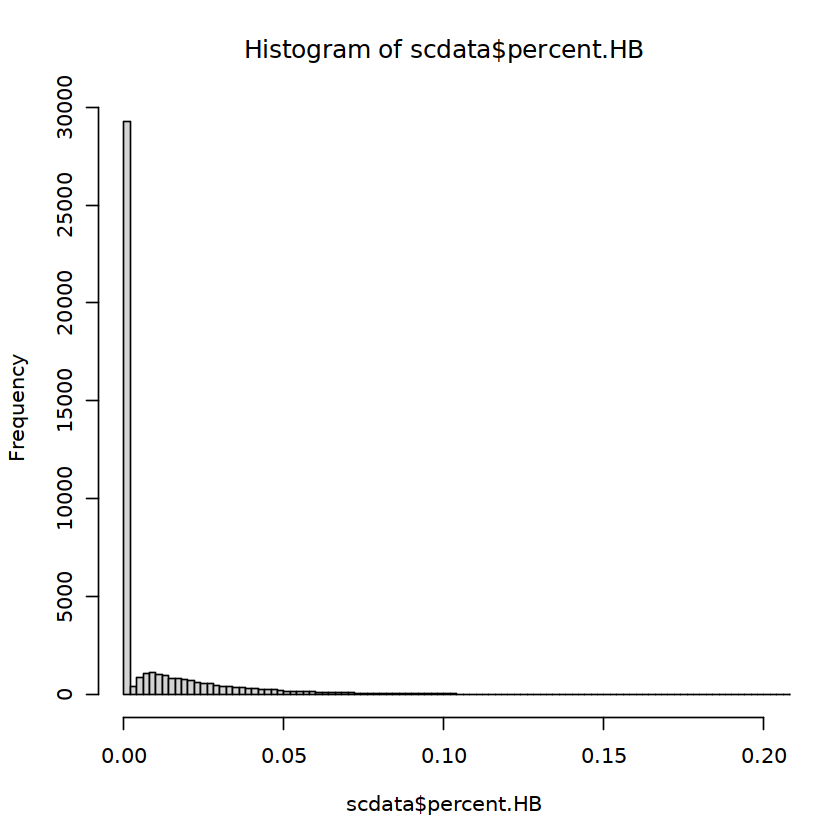

In [15]:
hist(scdata$percent.HB,breaks = 30000,xlim = c(0,0.2))

In [16]:
table(scdata$percent.HB>0.1)


FALSE  TRUE 
45622   808 

In [ ]:
scdata=subset(scdata,subset = percent.HB < 0.1)

In [18]:
scdata$percent.HB=NULL

# add metadata

In [19]:
table(scdata$sampleID)


  148_T1   148_T3 142_T5-4   132_T1   142_T2    18_T3    18_T4    17_T4 
    5110     3812     4879     4387     4389     5304     2109     7870 
  151_T4      WT1      WT2 
    5141     1387     1232 

In [20]:
sampleType=as.character(scdata$sampleID)

In [21]:
sampleType=ifelse(str_detect(sampleType,"_T"),"tumor","normal")
table(sampleType)

sampleType
normal  tumor 
  2619  43001 

In [22]:
scdata[["sampleType"]]=sampleType

In [23]:
sampleTypeFine=as.character(scdata$sampleID)

In [24]:
tumor_index=str_which(sampleTypeFine,"_T")

In [25]:
sampleTypeFine[tumor_index]=rep("tumor",length(tumor_index))
table(sampleTypeFine)

sampleTypeFine
tumor   WT1   WT2 
43001  1387  1232 

In [26]:
scdata[["sampleTypeFine"]]=sampleTypeFine

In [27]:
head(scdata@meta.data)

nCount_RNA nFeature_RNA sampleID percent.mt Phase sampleType
WT_1.bcHTXJ  5633      2155         WT1      3.586011   G1    normal    
WT_1.bcHGRE 10487      3855         WT1      5.912082   G2M   normal    
WT_1.bcHIFA  9429      3137         WT1      6.352742   G2M   normal    
WT_1.bcHFJN  7902      2746         WT1      7.884080   G1    normal    
WT_1.bcGOTP  7605      3330         WT1      4.865220   S     normal    
WT_1.bcFBTL  8837      2901         WT1      6.551997   G1    normal    
            sampleTypeFine
WT_1.bcHTXJ WT1           
WT_1.bcHGRE WT1           
WT_1.bcHIFA WT1           
WT_1.bcHFJN WT1           
WT_1.bcGOTP WT1           
WT_1.bcFBTL WT1

In [28]:
DefaultAssay(scdata)

[1] "RNA"

In [29]:
scdata=DietSeurat(scdata,assays="RNA")

# Integrate

## split data

In [ ]:
scdata[["RNA"]] = split(scdata[["RNA"]], f = scdata$sampleID)
scdata

## process without integration

In [ ]:
scdata = SCTransform(scdata,vst.flavor = "v2",vars.to.regress =c("percent.mt"), verbose = FALSE) %>% RunPCA(verbose = FALSE)

In [ ]:
scdata = FindNeighbors(scdata, dims = 1:50, reduction = "pca", verbose = FALSE)
scdata = FindClusters(scdata, resolution = 1, cluster.name = "unintegrated_clusters", verbose = FALSE)
scdata = RunUMAP(scdata, dims = 1:50, reduction = "pca", reduction.name = "umap.unintegrated", verbose = FALSE)

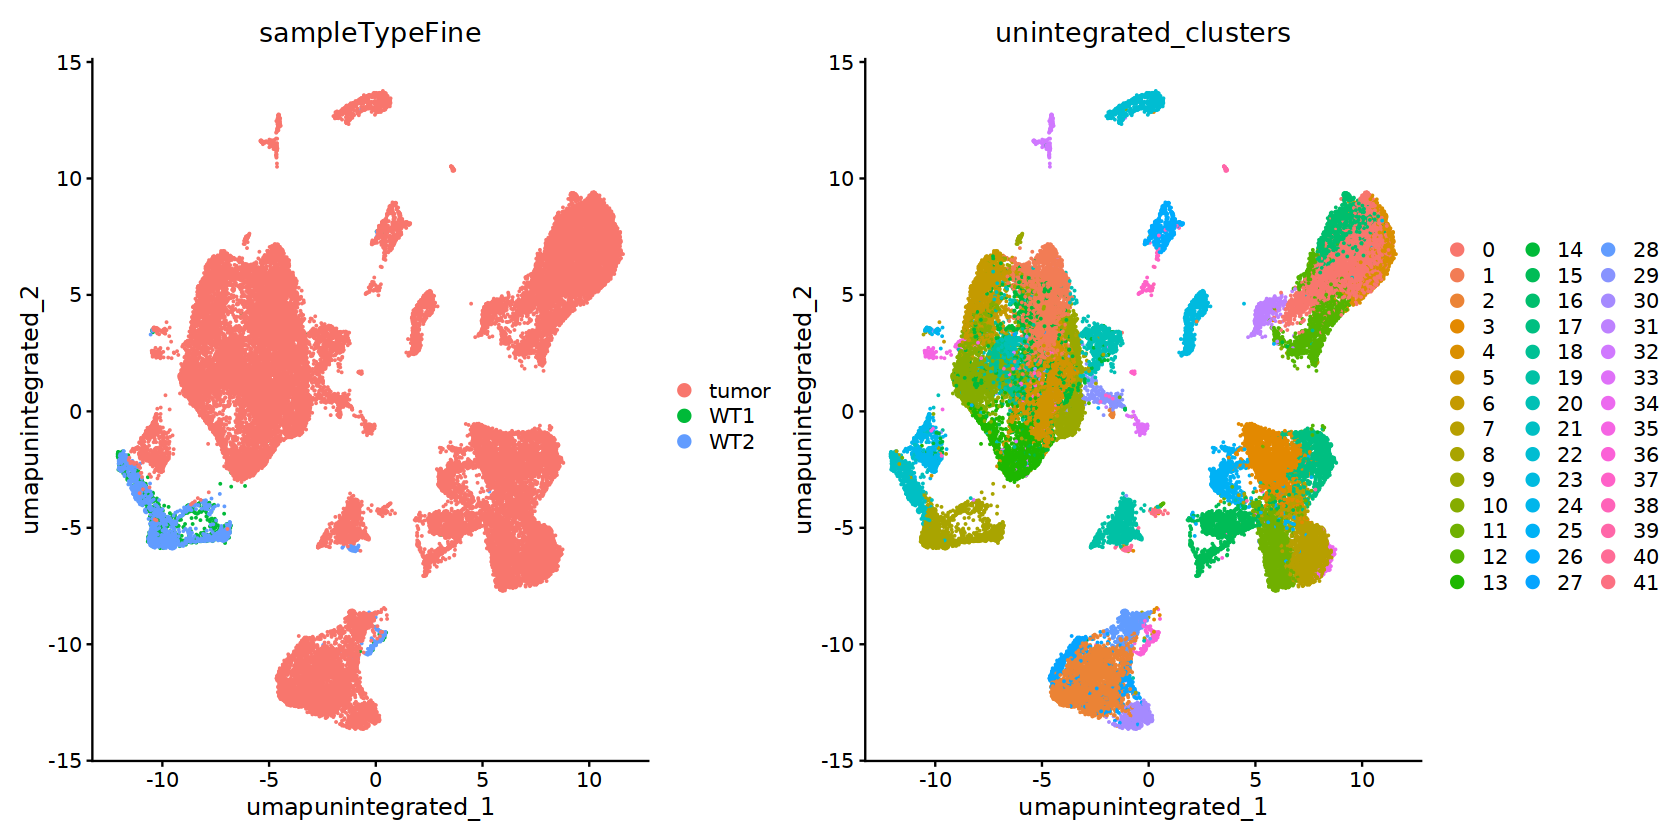

In [25]:
options(repr.plot.width=14)
DimPlot(scdata, reduction = "umap.unintegrated", group.by = c("sampleTypeFine", "unintegrated_clusters"))

In [ ]:
saveRDS(scdata,"results/sctBeforeIntegrate")

In [24]:
scdata=readRDS("results/sctBeforeIntegrate")

# process with integration

## CCAIntegration

In [ ]:
scdata = IntegrateLayers(object = scdata, method = CCAIntegration, normalization.method = "SCT", 
                        orig.reduction = "pca", new.reduction = "integrated.cca",
                        verbose = F)

## RPCA

In [4]:
scdata = IntegrateLayers(object = scdata, method = RPCAIntegration, normalization.method = "SCT", 
                        orig.reduction = "pca", new.reduction = "integrated.rpca",
                        verbose = F)

## harmony

In [ ]:
scdata = IntegrateLayers(object = scdata, method = HarmonyIntegration, normalization.method = "SCT", assay = "SCT",
                        orig.reduction = "pca", new.reduction = "integrated.harmony",max.iter.cluster = 200L,npcs = 50L,
                        verbose = F)

## mnn

In [6]:
scdata$sampleTypeFine=factor(scdata$sampleTypeFine,levels = c("tumor","WT1","WT2"))

## integrated plot

### CCA plot

In [8]:
scdata = FindNeighbors(scdata, reduction = "integrated.cca", dims = 1:50,verbose = F)
scdata = FindClusters(scdata, resolution = 1,cluster.name = "cca_cluster",verbose = F)
scdata = RunUMAP(scdata, reduction = "integrated.cca", dims = 1:50, reduction.name = "umap.cca",verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


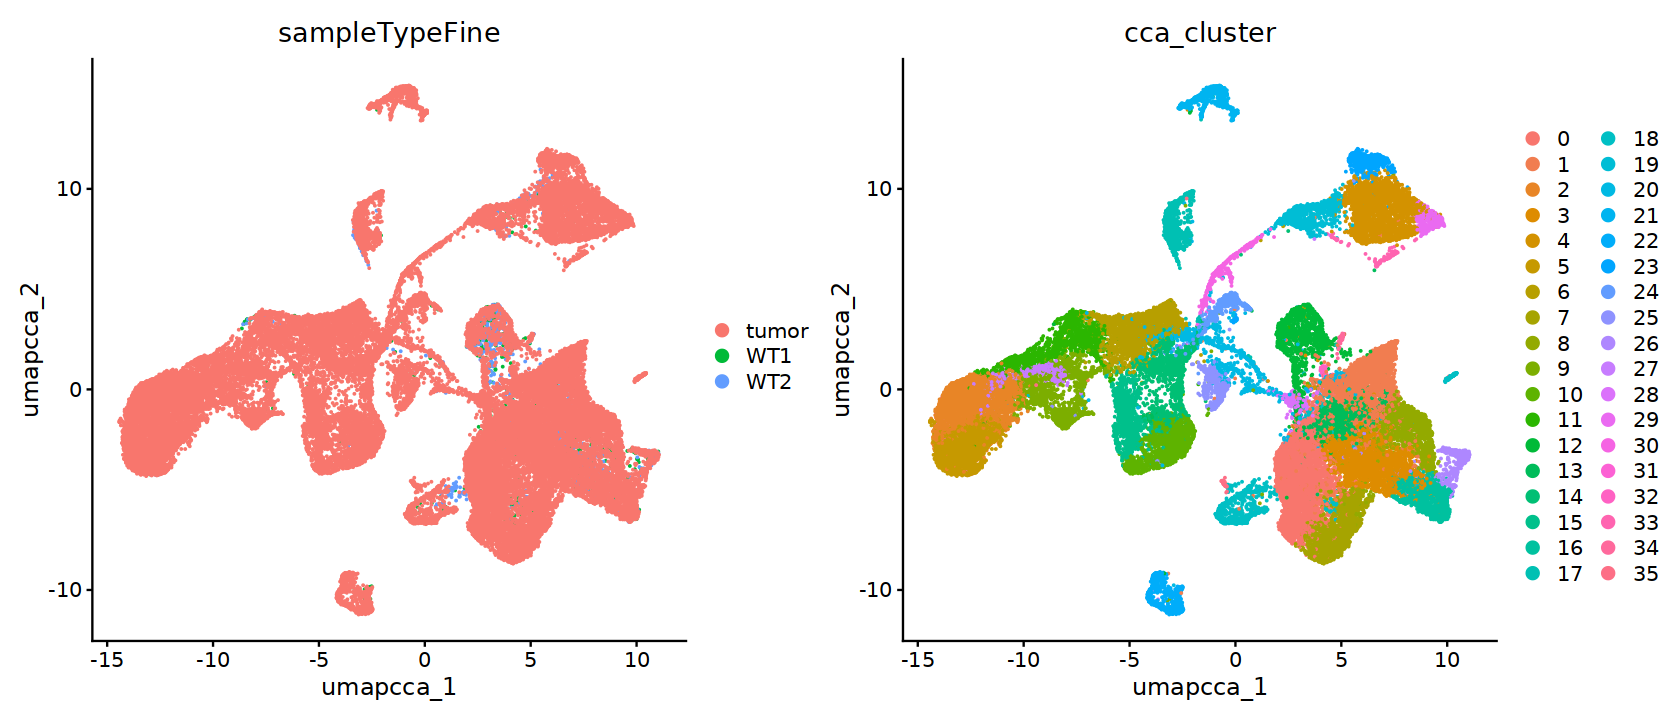

In [9]:
options(repr.plot.width=14,repr.plot.height=6)
DimPlot(scdata,reduction = "umap.cca",
  group.by = c("sampleTypeFine", "cca_cluster"))

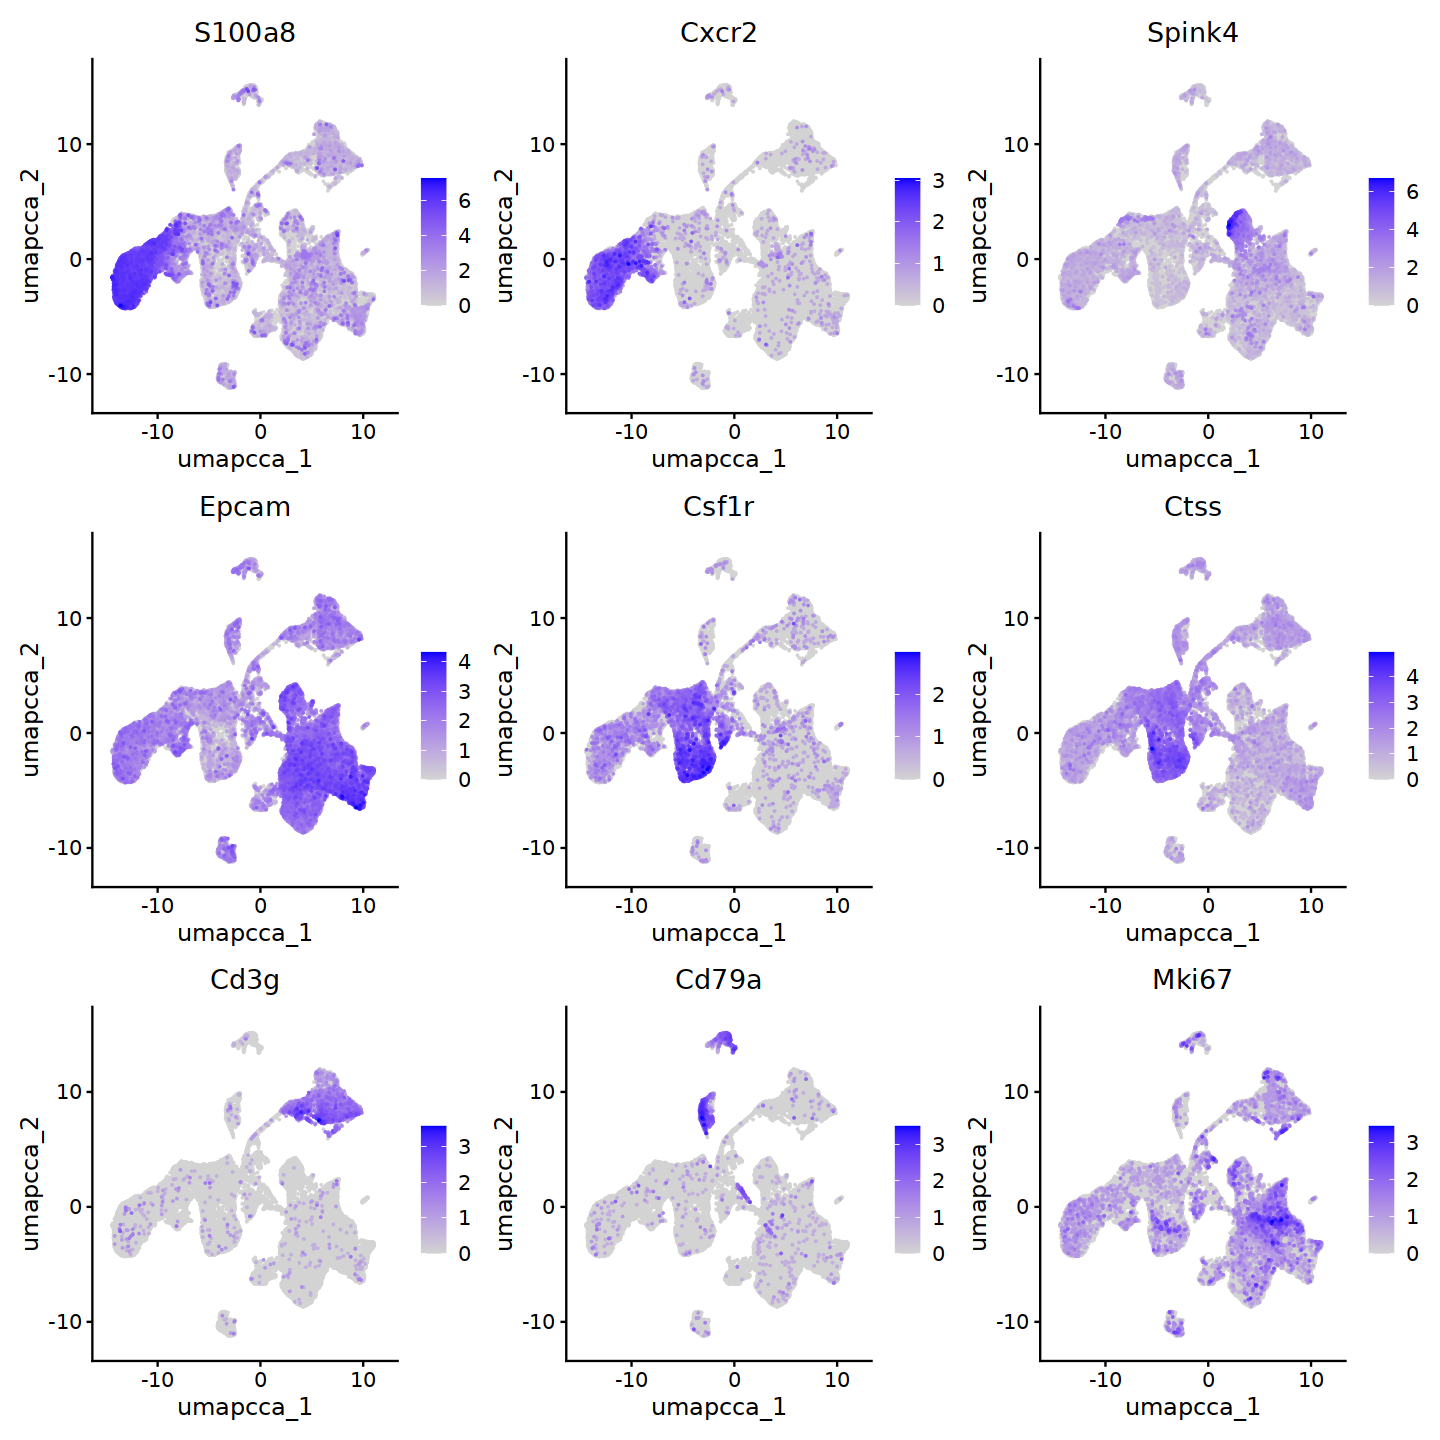

In [10]:
options(repr.plot.width=12,repr.plot.height=12)
FeaturePlot(scdata, features = c("S100a8","Cxcr2","Spink4",
                                 "Epcam","Csf1r","Ctss",
                                 "Cd3g","Cd79a","Mki67"),
            reduction = "umap.cca",
            ncol=3,order = T)

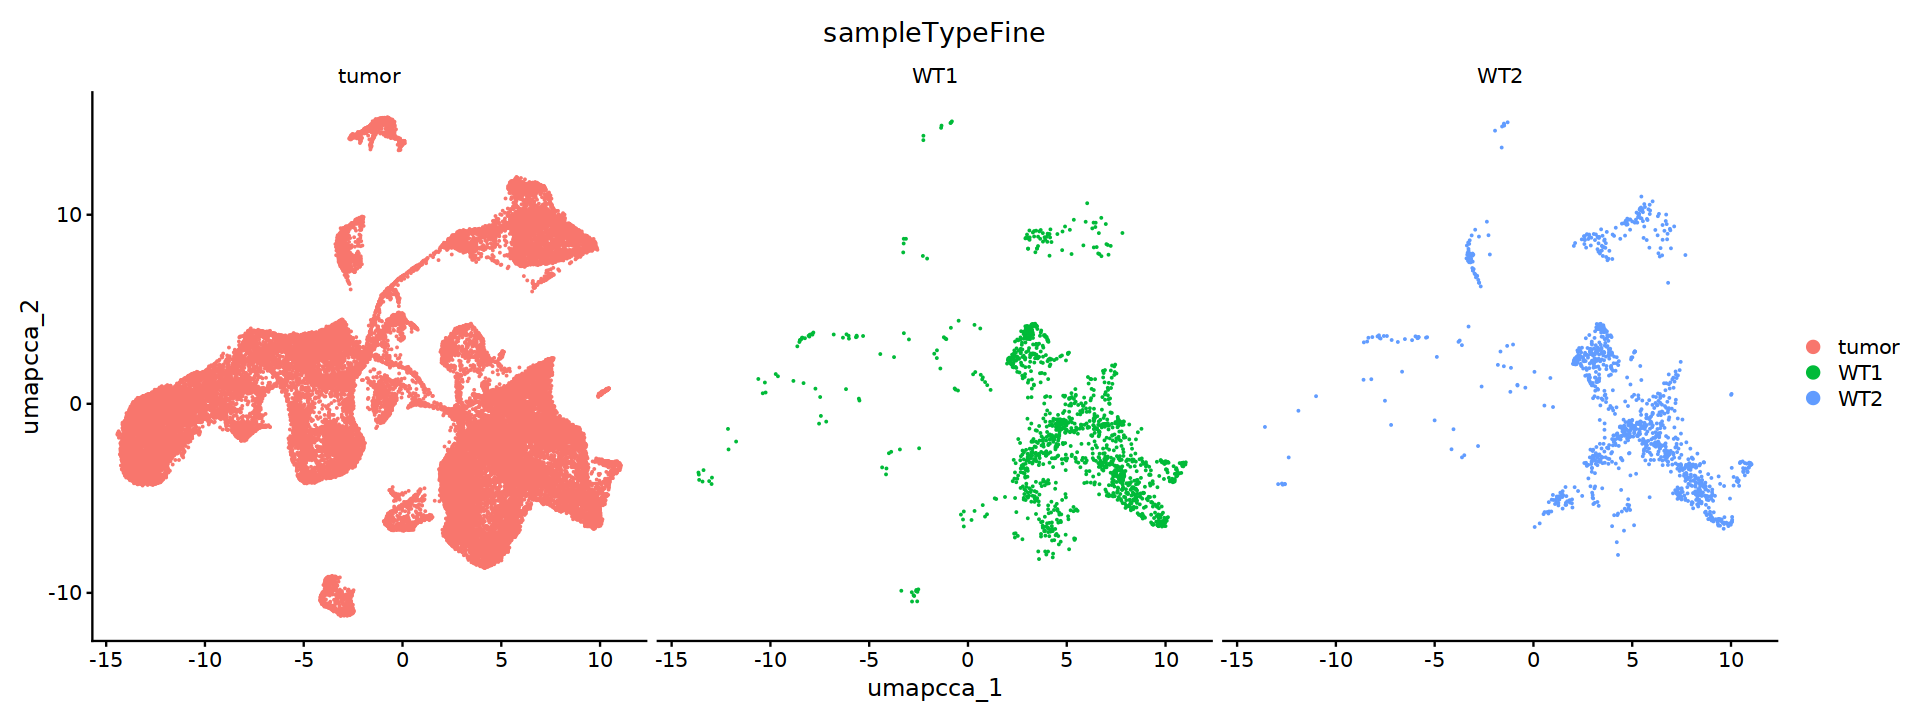

In [11]:
options(repr.plot.width=16,repr.plot.height=6)
DimPlot(scdata,reduction = "umap.cca",
  split.by = c("sampleTypeFine"),group.by = c("sampleTypeFine"))

### RPCA plot

In [12]:
scdata = FindNeighbors(scdata, reduction = "integrated.rpca", dims = 1:50,verbose = F)
scdata = FindClusters(scdata, resolution = 1,cluster.name = "rpca_cluster",verbose = F)
scdata = RunUMAP(scdata, reduction = "integrated.rpca", dims = 1:50, reduction.name = "umap.rpca",verbose = F)

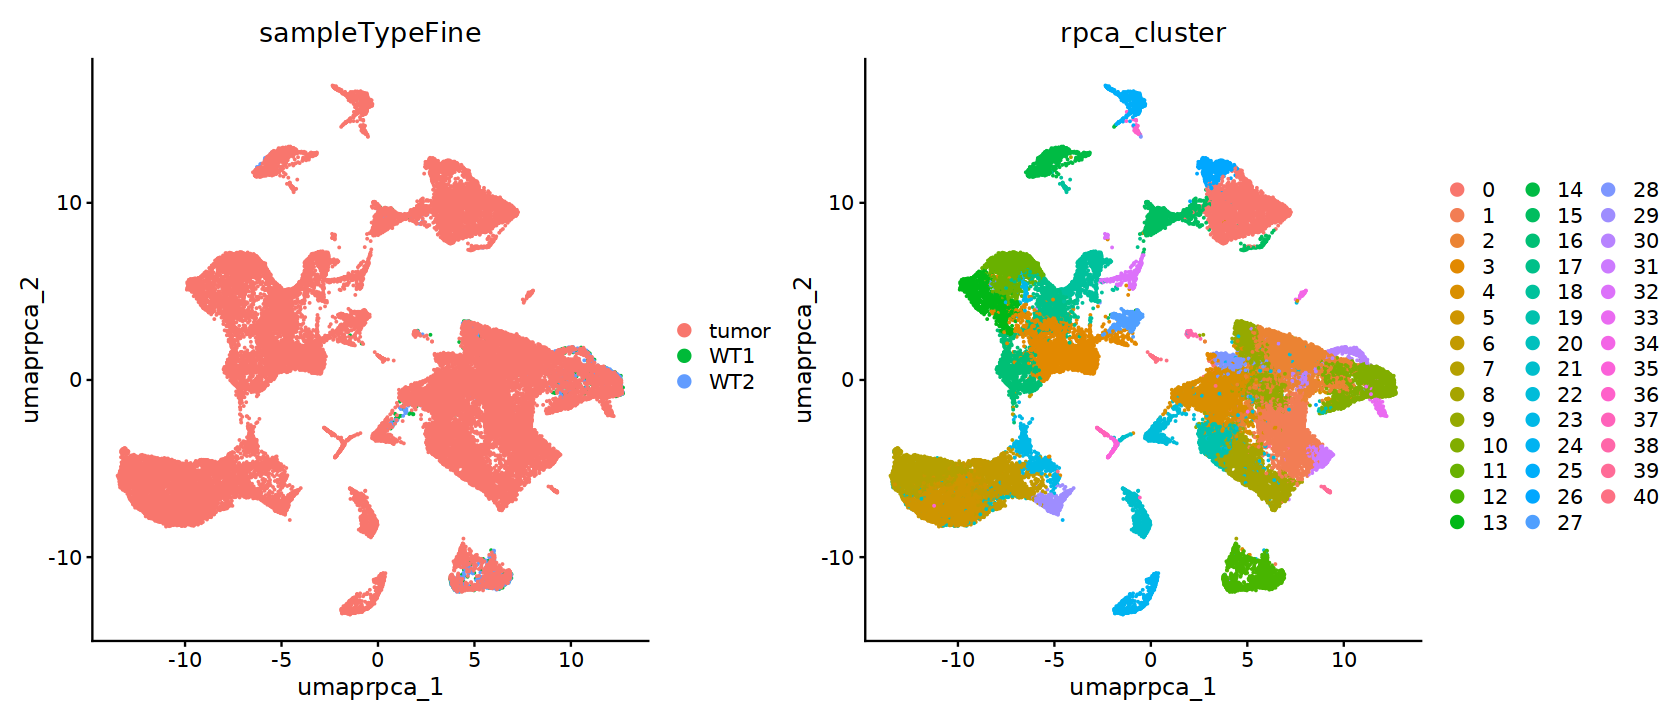

In [13]:
options(repr.plot.width=14,repr.plot.height=6)
DimPlot(scdata,reduction = "umap.rpca",
  group.by = c("sampleTypeFine", "rpca_cluster"))

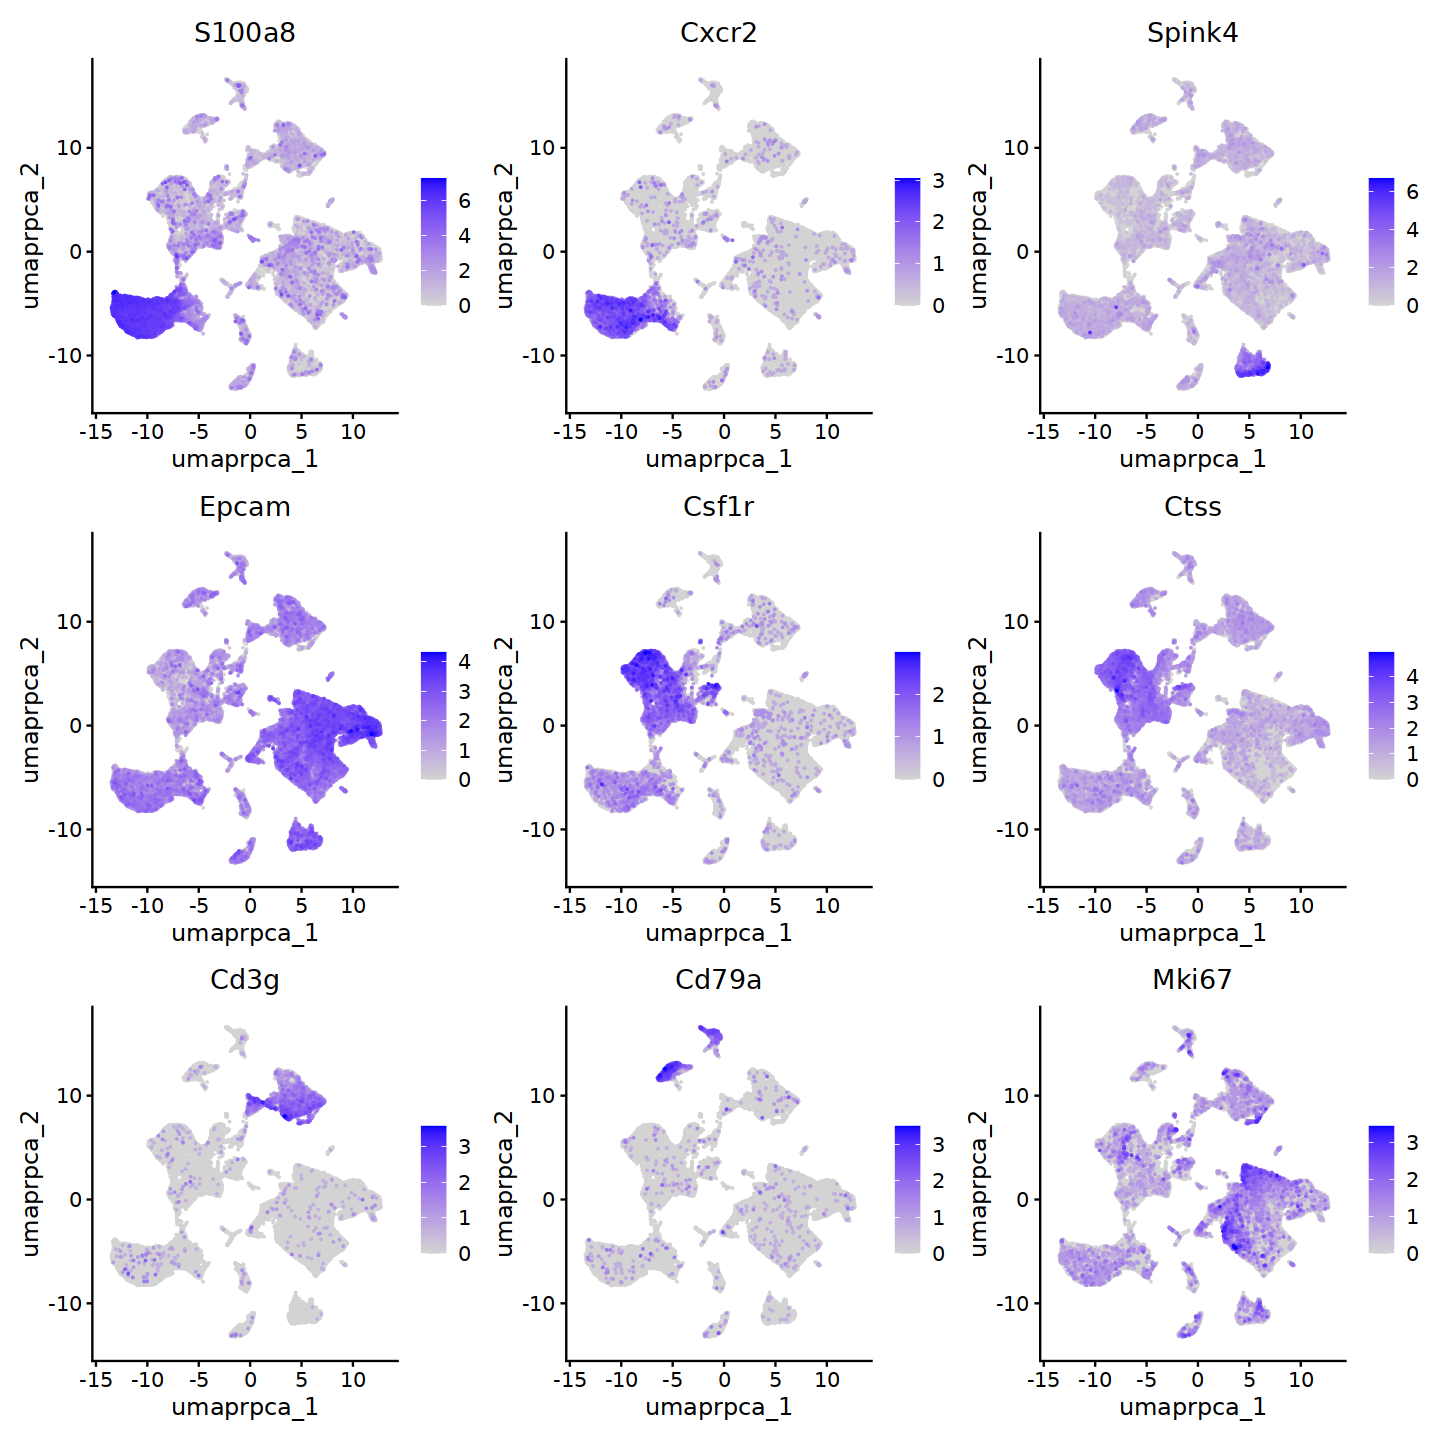

In [14]:
options(repr.plot.width=12,repr.plot.height=12)
FeaturePlot(scdata, features = c("S100a8","Cxcr2","Spink4",
                                 "Epcam","Csf1r","Ctss",
                                 "Cd3g","Cd79a","Mki67"),
            reduction = "umap.rpca",
            ncol=3,order = T)

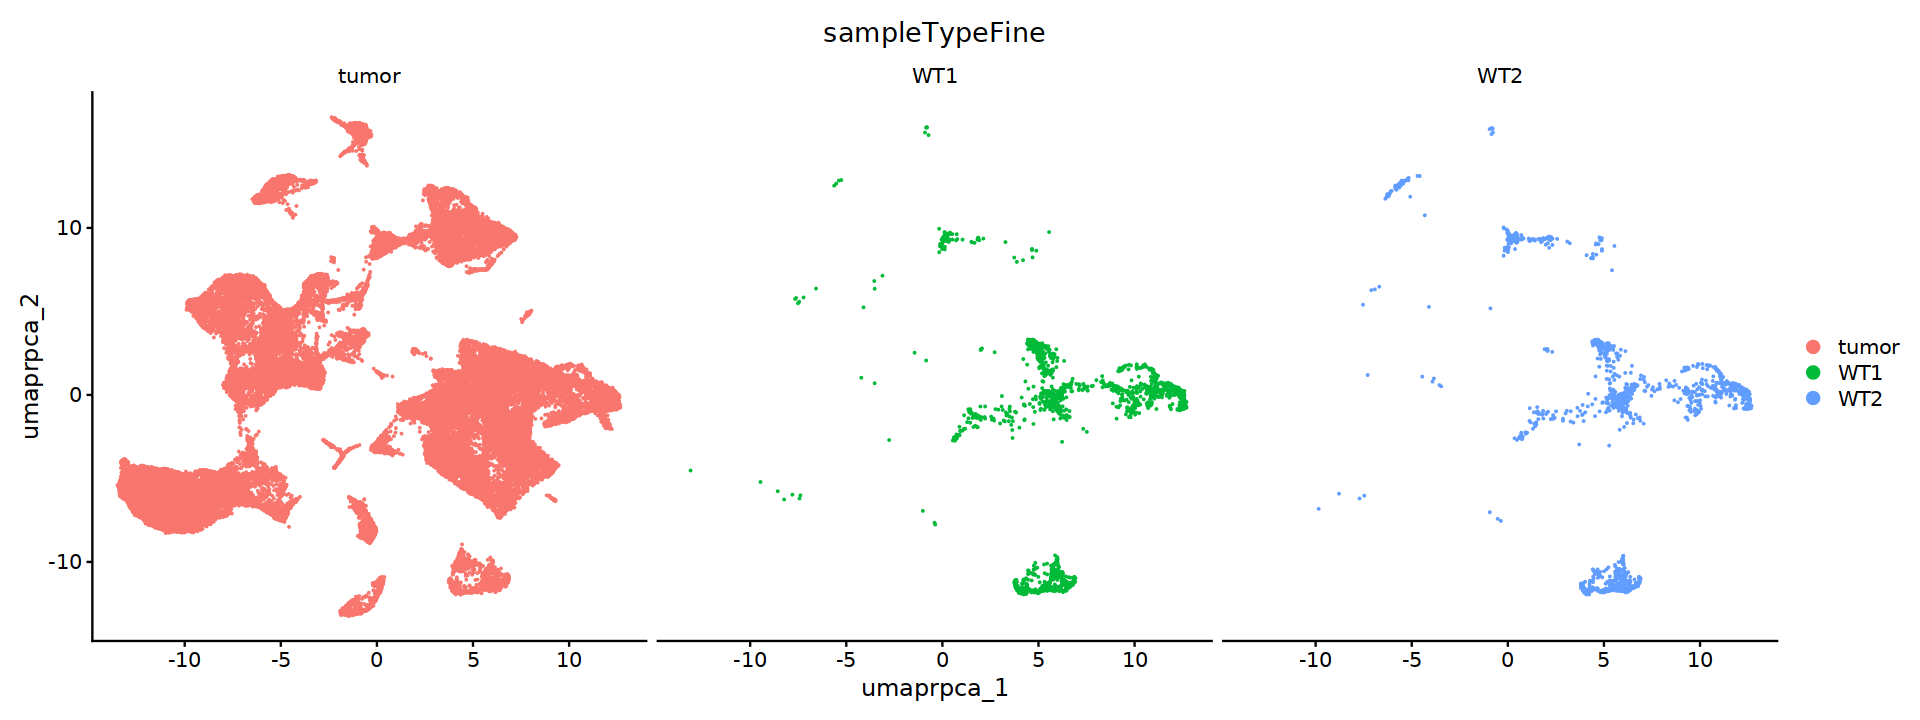

In [15]:
options(repr.plot.width=16,repr.plot.height=6)
DimPlot(scdata,reduction = "umap.rpca",
  split.by = c("sampleTypeFine"),group.by = c("sampleTypeFine"))

### harmony plot

In [203]:
scdata = RunUMAP(scdata, reduction = "integrated.harmony", dims = 1:30, reduction.name = "umap.harmony",verbose = F)

In [204]:
scdata = FindNeighbors(scdata, reduction = "integrated.harmony", dims = 1:30,verbose = F)

In [205]:
scdata = FindClusters(scdata, resolution = 0.4,cluster.name = "harmony_cluster",verbose = F)

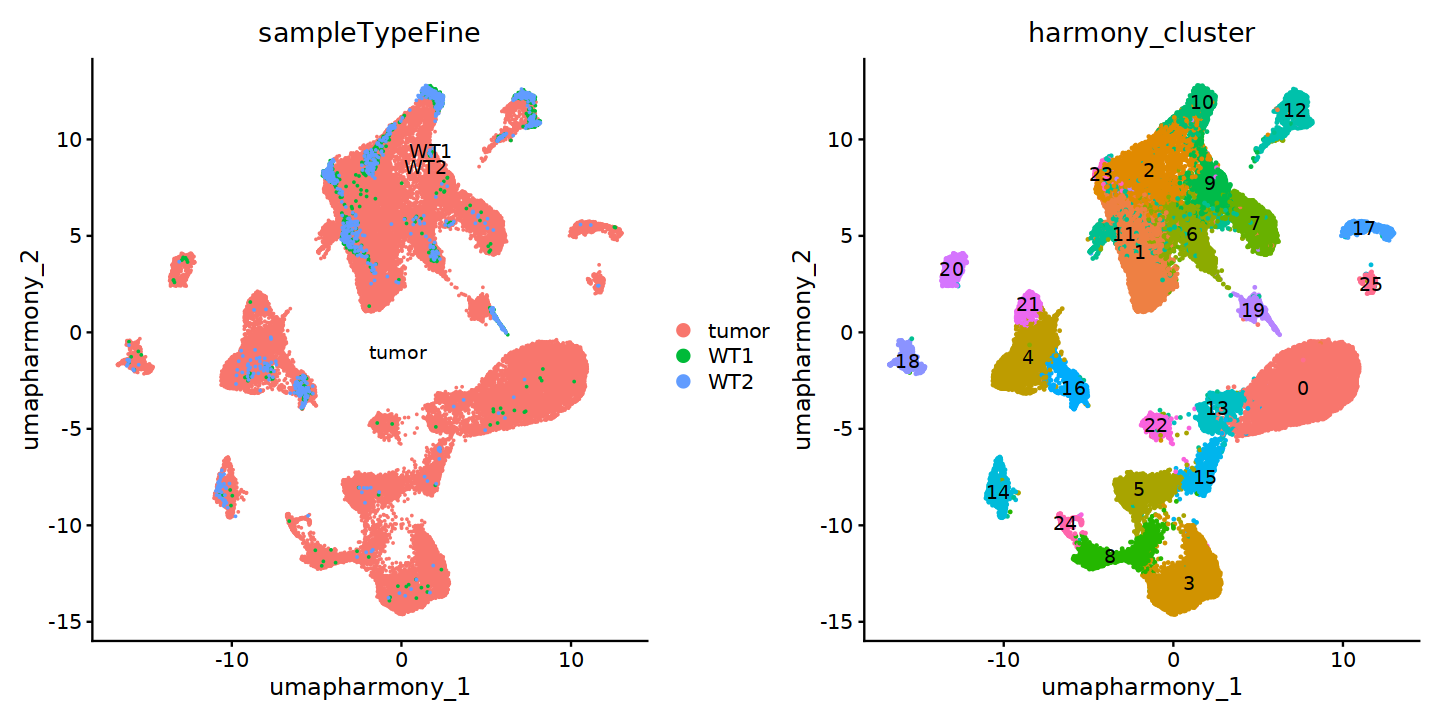

In [224]:
options(repr.plot.width=12,repr.plot.height=6)
#pdf("results/plot/umap_harmony.pdf",width = 12,height = 6)
a=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c("sampleTypeFine"), label = T,order=T,pt.size=0.01)
b=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "harmony_cluster"), label = T,order=F,pt.size=0.3)+NoLegend()
a|b
#dev.off()

In [ ]:
options(repr.plot.width=12,repr.plot.height=20)
DimPlot(scdata,reduction = "umap.harmony",
  split.by = c( "harmony_cluster"), label = T,order=F,pt.size=0.01,ncol=5)+NoLegend()

In [225]:
ggsave(b,filename = "results/plot/umap_seurat.pdf",width = 10,height = 10)

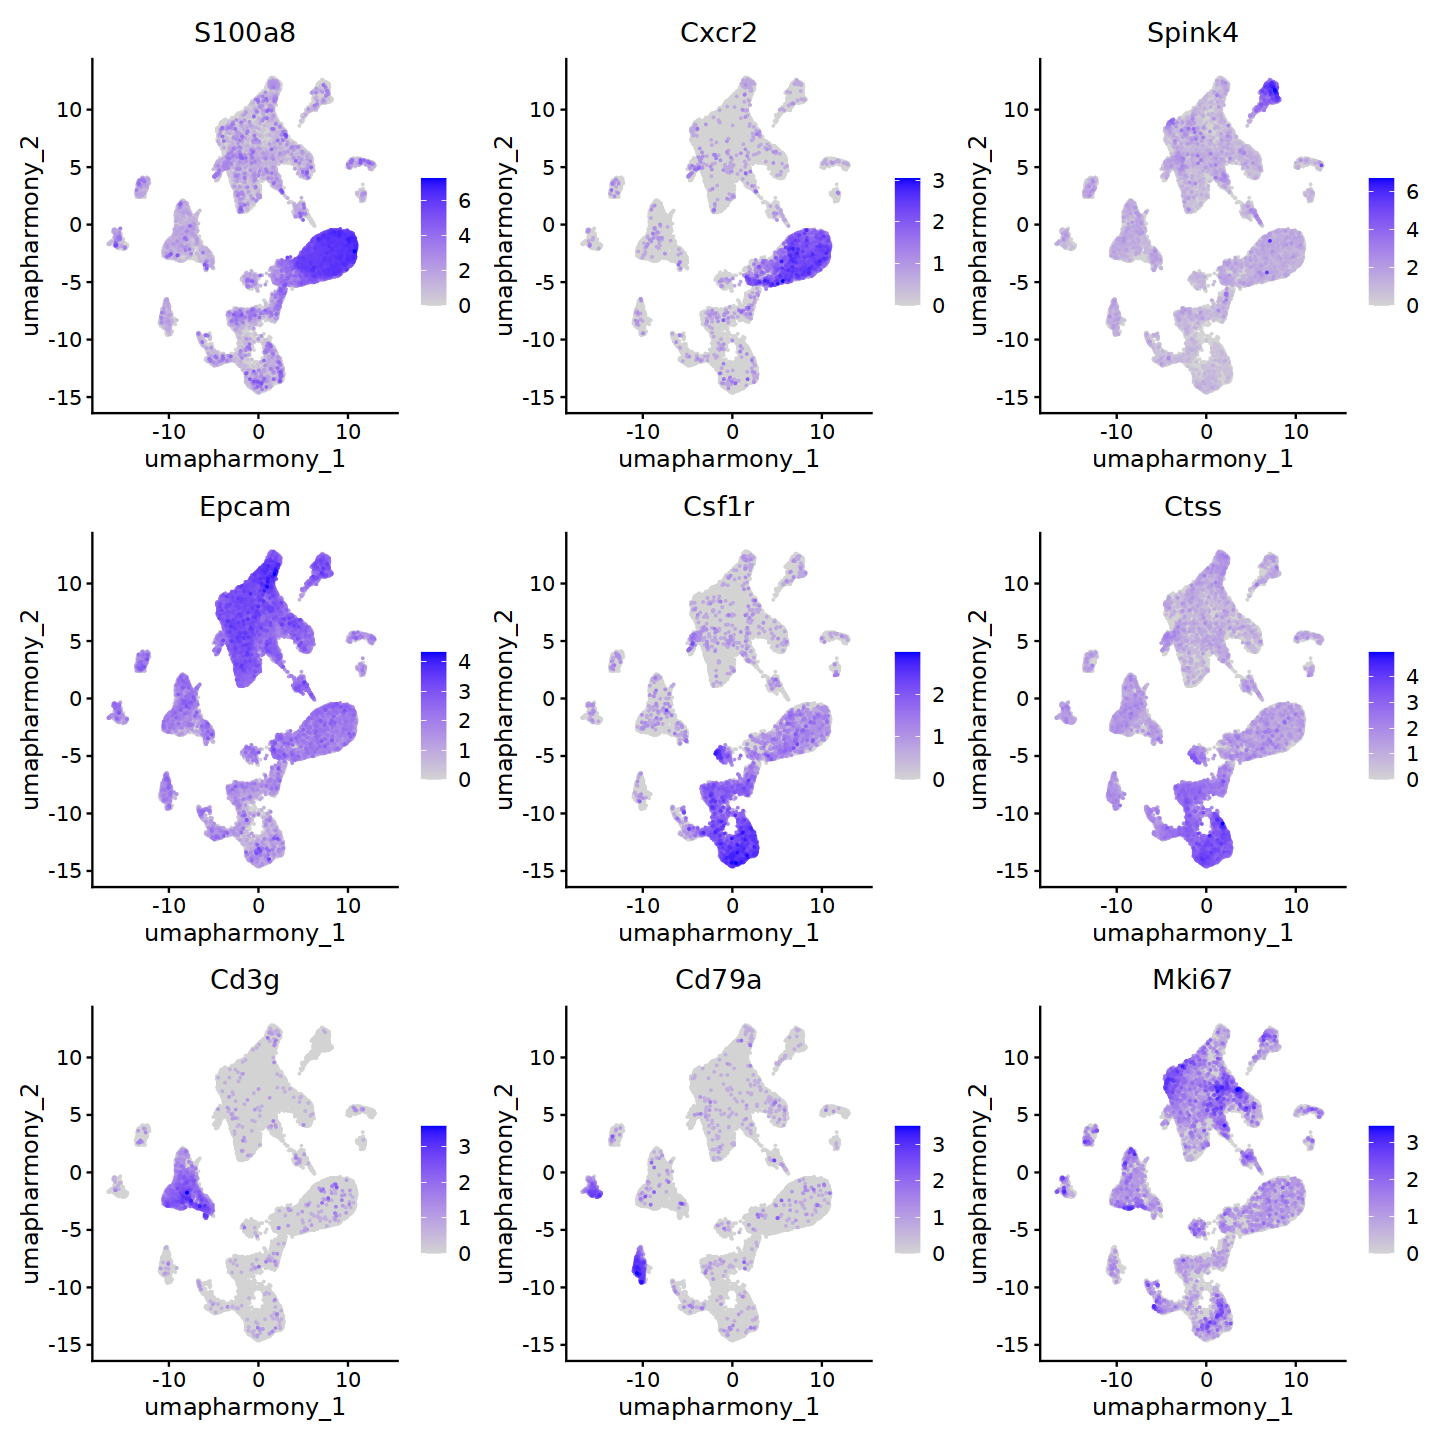

In [5]:
options(repr.plot.width=12,repr.plot.height=12)
FeaturePlot(scdata, features = c("S100a8","Cxcr2","Spink4",
                                 "Epcam","Csf1r","Ctss",
                                 "Cd3g","Cd79a","Mki67"),
            reduction = "umap.harmony",
            ncol=3,order = T)

In [10]:
head(scdata@meta.data)

nCount_RNA nFeature_RNA sampleID percent.mt Phase sampleType
WT_1.bcHTXJ  5633      2155         WT1      3.586011   G1    normal    
WT_1.bcHGRE 10487      3855         WT1      5.912082   G2M   normal    
WT_1.bcHIFA  9429      3137         WT1      6.352742   G2M   normal    
WT_1.bcHFJN  7902      2746         WT1      7.884080   G1    normal    
WT_1.bcGOTP  7605      3330         WT1      4.865220   S     normal    
WT_1.bcFBTL  8837      2901         WT1      6.551997   G1    normal    
            sampleTypeFine nCount_SCT nFeature_SCT unintegrated_clusters
WT_1.bcHTXJ WT1            2575       1386         8                    
WT_1.bcHGRE WT1            2180       1408         8                    
WT_1.bcHIFA WT1            2197       1152         8                    
WT_1.bcHFJN WT1            2205       1178         8                    
WT_1.bcGOTP WT1            2136       1383         20                   
WT_1.bcFBTL WT1            2213       1189         8                    
            seurat_clusters cca_cluster rpca_cluster harmony_cluster
WT_1.bcHTXJ 10              16          10           10             
WT_1.bcHGRE 11              0           9            11             
WT_1.bcHIFA 10              16          10           10             
WT_1.bcHFJN 10              16          10           10             
WT_1.bcGOTP 0               11          22           0              
WT_1.bcFBTL 10              3           10           10

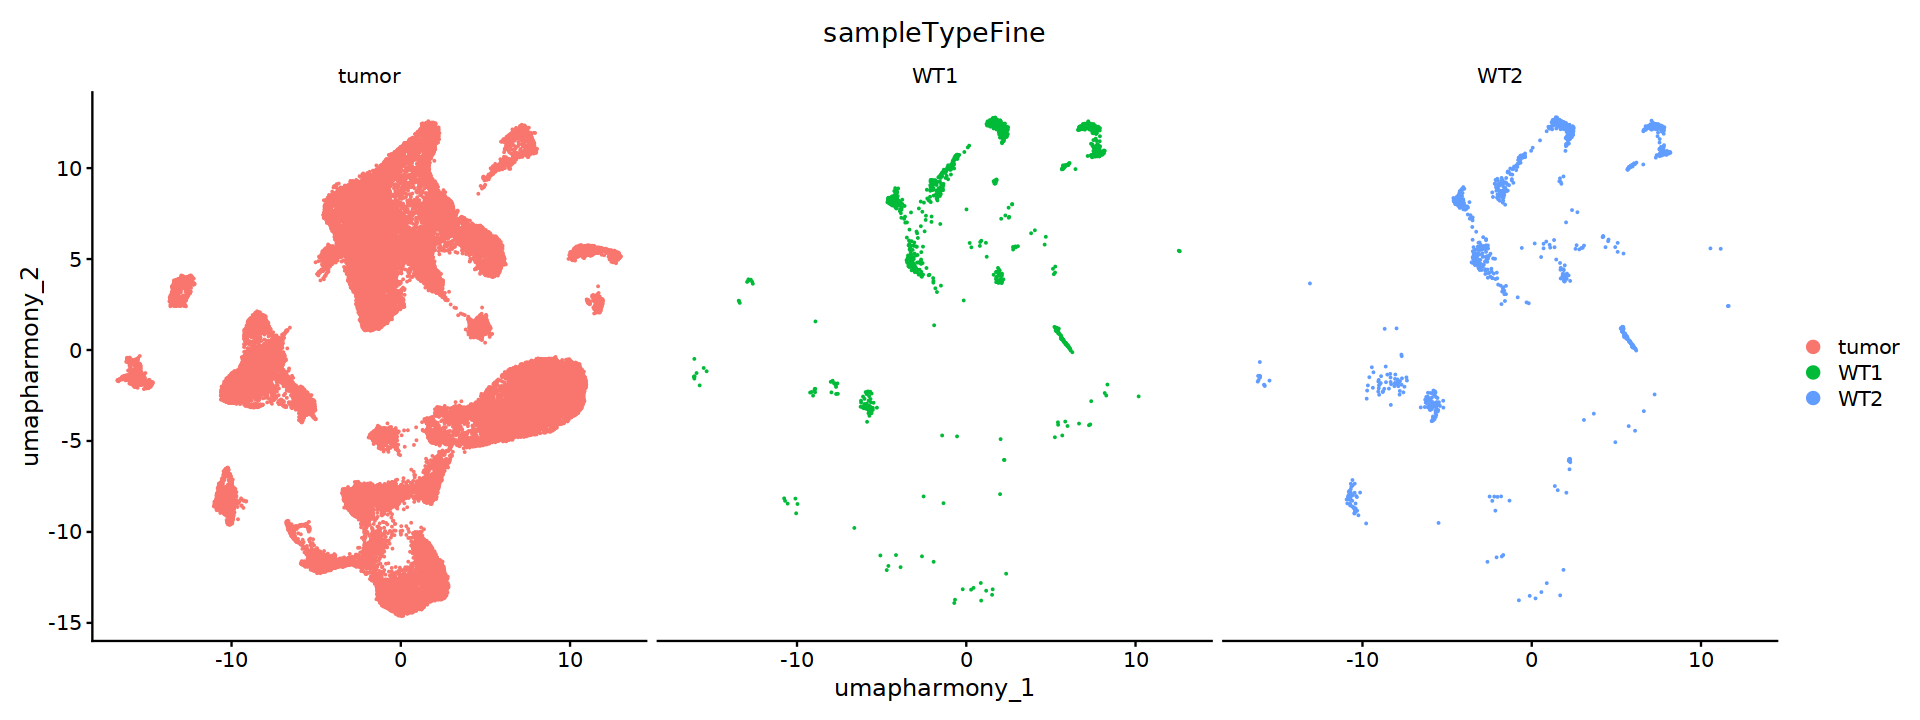

In [4]:
options(repr.plot.width=16,repr.plot.height=6)
DimPlot(scdata,reduction = "umap.harmony",
  split.by = c("sampleTypeFine"),group.by = c("sampleTypeFine"))

### save integrated data

In [211]:
saveRDS(scdata,"results/sctIntegrated")

In [3]:
scdata=readRDS("results/sctIntegrated")

# DEGs analysis

## finderAllMarker

In [221]:
Idents(scdata)="harmony_cluster"
scdata = PrepSCTFindMarkers(scdata)

Found 11 SCT models. Recorrecting SCT counts using minimum median counts: 2231



In [222]:
markers=FindAllMarkers(scdata,test.use = "wilcox",only.pos = T,logfc.threshold = 0.25, assay = "SCT", verbose = F)

In [223]:
write.table(markers,"results/markers.csv",sep = ",",col.names = T)

## subcluster marker

In [20]:
## epithelium:c(1,2,6,7,9,10,11,12,19,23)
cluster=c(1,2,6,7,9,10,11,12,19,23)

In [40]:
## macrophage:c(3,5,8,13,15,22,24)
cluster=c(3,5,8,13,15,22,24)

In [50]:
## t:c(4,16,21)
cluster=c(4,16,21)

In [55]:
## b:14,18
cluster=c(14,18)

In [56]:
Idents(scdata)="harmony_cluster"
submarkers=vector("list",length = length(cluster))
    names(submarkers)=cluster
    for(i in seq_along(cluster)){   
    submarkers[[i]]=FindMarkers(scdata, assay = "SCT", ident.1 = cluster[i], 
                                                      ident.2 = setdiff(cluster,cluster[i]), min.pct = 0.3)%>%arrange(-avg_log2FC)
}

In [25]:
epiSubmakers=submarkers

In [ ]:
head(epiSubmakers$`19`,n=30)

In [42]:
macroSubmakers=submarkers

In [ ]:
head(macroSubmakers$`3`,n=30)

In [52]:
tSubmakers=submarkers

In [57]:
bSubmakers=submarkers

In [ ]:
head(bSubmakers$`18`,n=30)

# metadata annatation

In [4]:
manualAnnotation=read_xlsx("results/manualMarkers.xlsx",col_names = T,sheet = "Sheet1")

In [5]:
manualAnnotation

cluster main        fine         
1   0      Neutrophil  Neutrophil   
2   1      Epithelial  Epi-Mt3      
3   2      Epithelial  Epi-Mgst3    
4   3      Macrophage  Macro-Trem2  
5   4      T           T-Regulatory 
6   5      Macrophage  Macro-Chil3  
7   6      Epithelial  Epi-Peak1    
8   7      Epithelial  Epi-Mdga2    
9   8      Macrophage  Macro-Ifitm1 
10  9      Epithelial  Epi-Ptprd    
11 10      Epithelial  Epi-Krt20    
12 11      Epithelial  Epi-Srgn     
13 12      Epithelial  Epi-Goblet   
14 13      Macrophage  Macro-Acod1  
15 14      B           B            
16 15      Macrophage  Macro-Cxcl3  
17 16      T           T-Cytotoxic  
18 17      Endothelial Endothelial  
19 18      B           B-Plasma     
20 19      Epithelial  Epi-Arglu1   
21 20      Mast        Mast         
22 21      T           T-Progenitor 
23 22      Macrophage  Macro-St18   
24 23      Epithelial  Epi-Stem-like
25 24      Macrophage  Macro-Ccr7   
26 25      Fibroblast  Fibroblast

In [6]:
main=manualAnnotation$main
fine=manualAnnotation$fine

In [ ]:
main
fine
length(main)
length(fine)

In [ ]:
levels(scdata$harmony_cluster)
str(scdata$harmony_cluster)

In [9]:
mainCluster=factor(scdata$harmony_cluster,labels = main)
fineCluster=factor(scdata$harmony_cluster,labels = fine)

In [10]:
scdata[["main"]]=mainCluster
scdata[["fine"]]=fineCluster

In [12]:
scdata$fine=factor(scdata$fine,levels=c(
"Epi-Mt3","Epi-Mgst3","Epi-Peak1","Epi-Mdga2","Epi-Ptprd","Epi-Krt20","Epi-Srgn","Epi-Goblet","Epi-Arglu1","Epi-Stem-like",
"Fibroblast",
"Endothelial",
"Mast",
"T-Regulatory","T-Cytotoxic","T-Progenitor",
"B","B-Plasma",
"Neutrophil",
"Macro-Trem2","Macro-Chil3","Macro-Ifitm1","Macro-Acod1","Macro-Cxcl3","Macro-St18","Macro-Ccr7"
))

## set color

In [7]:
mainColor=paletteer_d("basetheme::clean")[c(1:8)]
fineColor=paletteer_d("ggsci::default_ucscgb")

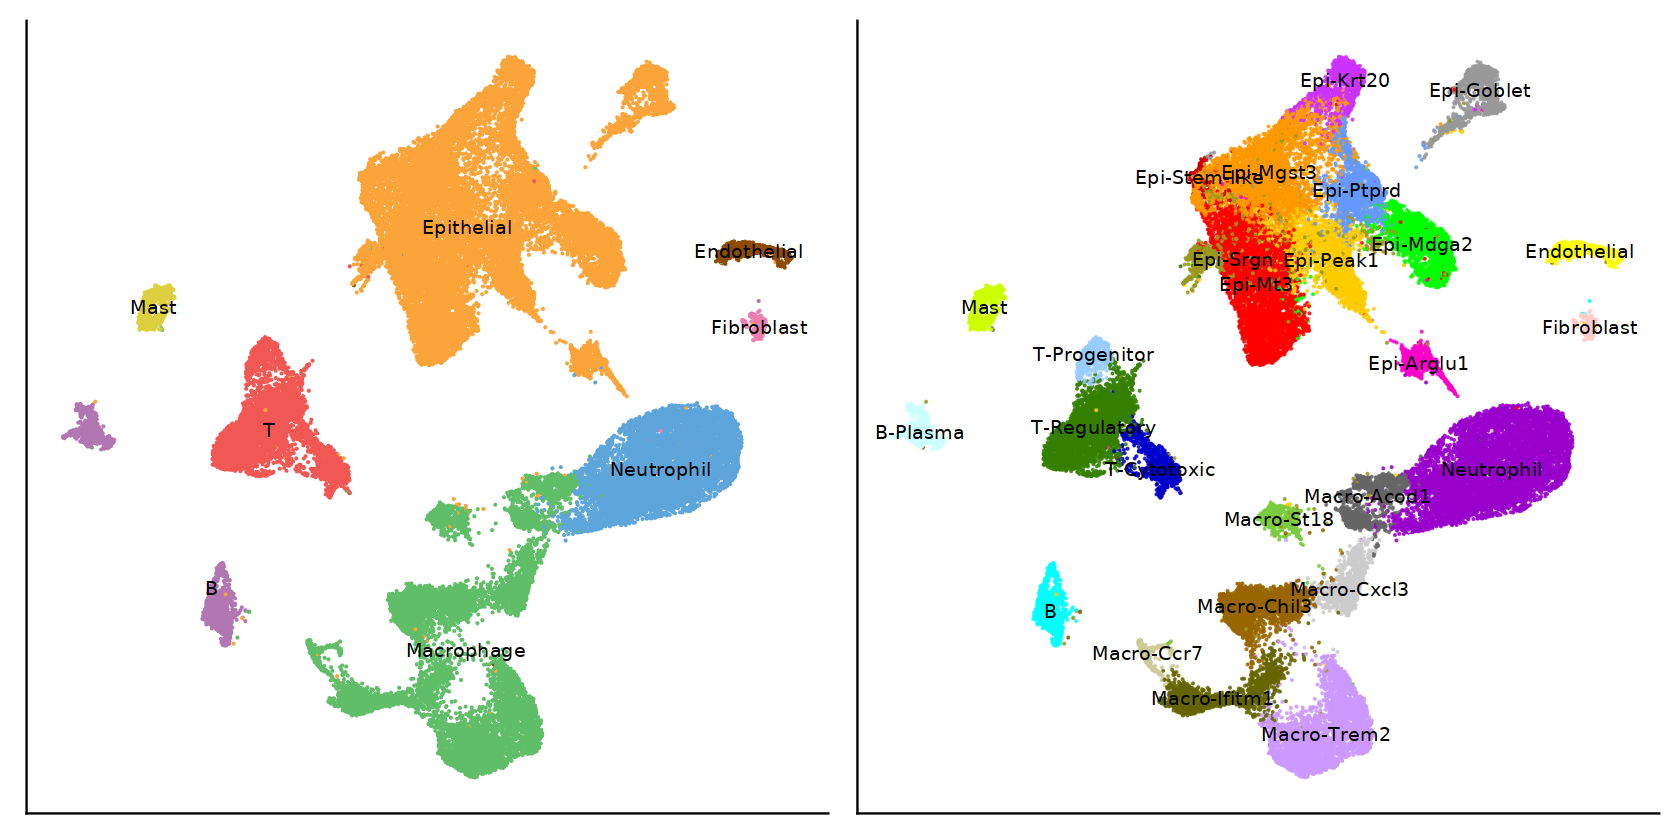

In [8]:
options(repr.plot.width=14,repr.plot.height=7)
umapmain=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "main"), label = T,order=F,pt.size=0.1,cols=mainColor)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())+
NoLegend()


umapfine=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "fine"), label = T,order=F,pt.size=0.1,cols=fineColor,alpha=0.8)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())+
NoLegend()
umapmain+umapfine

In [16]:
ggsave(umapmain,filename = "results/plot/umapmain.pdf",width = 15,height = 12)
ggsave(umapfine,filename = "results/plot/umapfine.pdf",width = 13,height = 10)

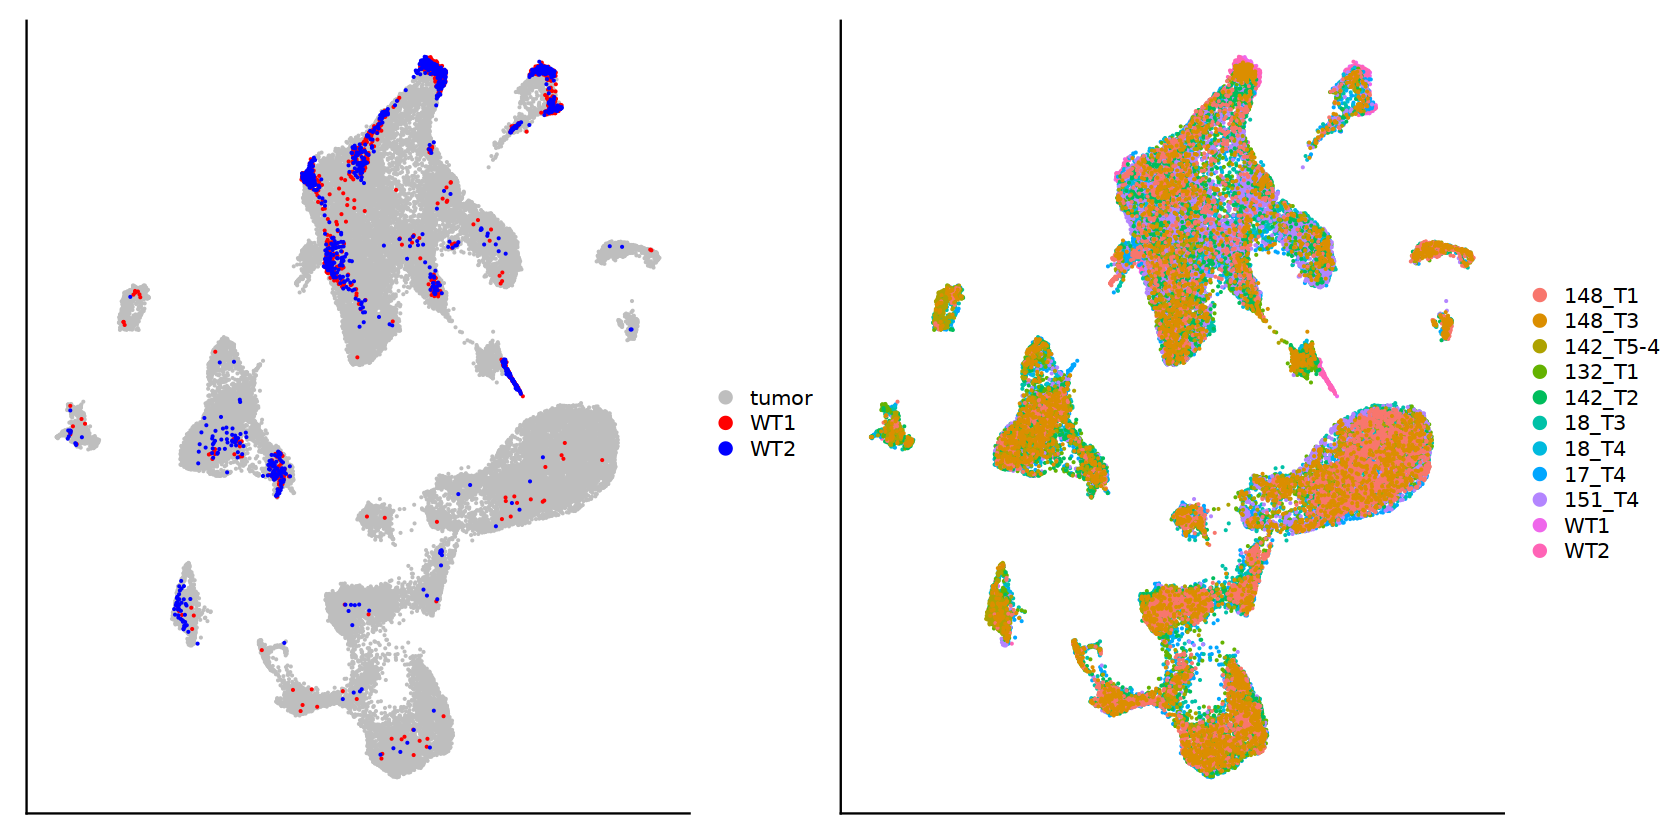

In [9]:
normalTumor=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "sampleTypeFine"), label = F,order=T,pt.size=0.1,cols=c("grey","red","blue"))+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())


bySample=DimPlot(scdata,reduction = "umap.harmony",
  group.by = c( "sampleID"), label = F,order=F,pt.size=0.1)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())
normalTumor+bySample

In [18]:
ggsave(normalTumor,filename = "results/plot/umapnormalTumor.pdf",width = 12,height = 12)
ggsave(bySample,filename = "results/plot/umapbySample.pdf",width = 13,height = 12)

# save annotation data

In [10]:
#saveRDS(scdata,"results/sctAnnotationSeuObj")

In [16]:
scdata=readRDS("results/sctAnnotationSeuObj")

In [17]:
scdata

An object of class Seurat 
50442 features across 45620 samples within 2 assays 
Active assay: SCT (22704 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 8 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, integrated.rpca, integrated.harmony, umap.cca, umap.rpca, umap.harmony

## DEGs for main

In [ ]:
Idents(scdata)="main"
mainMarkers=FindAllMarkers(scdata,test.use = "wilcox",only.pos = T,logfc.threshold = 0.25, assay = "SCT", verbose = F)

In [352]:
write.table(mainMarkers,"results/mainMarkers.csv",sep = ",",col.names = T)

# markergeneplot

## heatmap for main

### choose marker genes

In [22]:
chooseMainMarkers=read_xlsx("results/chooseMainMarkers.xlsx",col_names = T,sheet = "main")

In [ ]:
head(chooseMainMarkers)

In [24]:
chooseGene=unique(chooseMainMarkers$genes)

In [25]:
length(chooseGene)

[1] 39

### downsampling cells

In [26]:
heatmapSC=scdata

In [27]:
table(heatmapSC$main)


 Neutrophil  Epithelial  Macrophage           T           B Endothelial 
       7155       19554       10416        4864        1870         781 
       Mast  Fibroblast 
        722         258 

In [ ]:
mainClusterColor=c("Neutrophil","Epithelial","Macrophage","T","B","Endothelial","Mast","Fibroblast")
names(mainClusterColor)=mainColor
mainClusterColor

In [29]:
heatmapSC$main=factor(heatmapSC$main,levels = c("B","Endothelial","Epithelial","Fibroblast","Macrophage","Mast","Neutrophil","T"))

In [ ]:
table(heatmapSC$main)

In [31]:
orderMainClusterColor=mainClusterColor[c(5,6,2,8,3,7,1,4)]
orderMainClusterColor

#B276B2FF     #8D4B08FF     #FAA43AFF     #F17CB0FF     #60BD68FF 
          "B" "Endothelial"  "Epithelial"  "Fibroblast"  "Macrophage" 
    #DECF3FFF     #5DA5DAFF     #F15854FF 
       "Mast"  "Neutrophil"           "T"

In [ ]:
orderColor=names(orderMainClusterColor)
orderColor

In [33]:
Idents(heatmapSC)="main"
heatmapSC=subset(heatmapSC, downsample = 250)

In [ ]:
DefaultAssay(heatmapSC)="RNA"
heatmapSC=NormalizeData(heatmapSC,verbose=F)%>%
FindVariableFeatures(verbose=F)%>%
ScaleData(features = chooseGene,vars.to.regress = "percent.mt",verbose=F)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


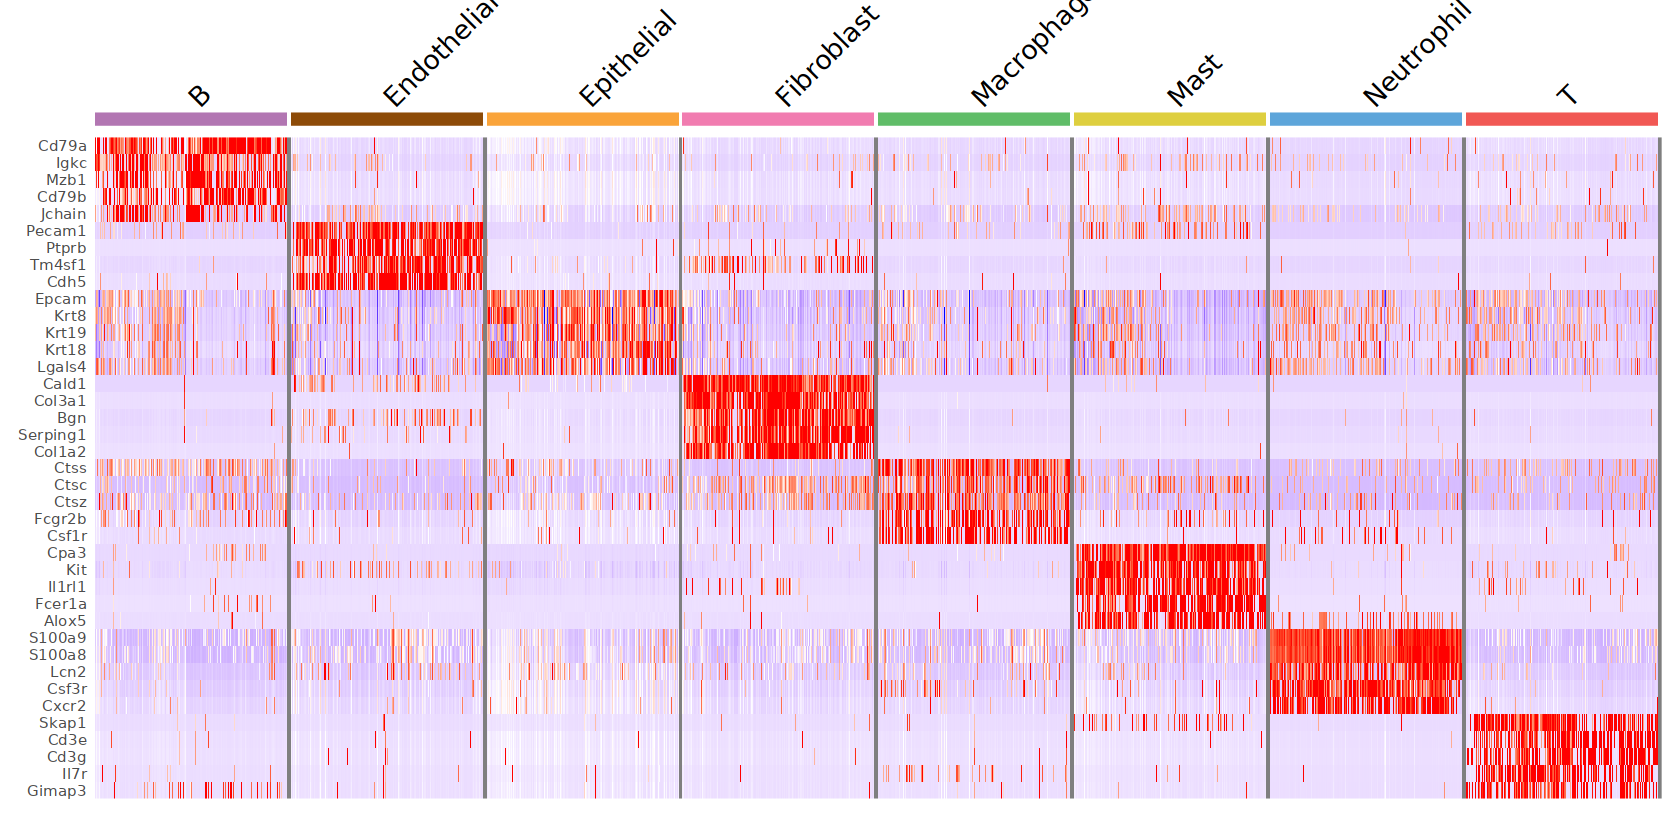

In [35]:
markerHeatMap=DoHeatmap(heatmapSC, features = chooseGene,group.colors = orderColor,group.by = "main")+
                       scale_fill_gradientn(colors = c("blue", "white", "red"))+NoLegend() 
markerHeatMap

In [70]:
ggsave(markerHeatMap,filename = "results/plot/MainmarkerHeatMap.pdf",width = 3,height = 5)

## bubblePlot for fine

In [18]:
chooseFineMarkers=read_xlsx("results/chooseMainMarkers.xlsx",col_names = T,sheet = "orderFine1")

In [19]:
head(chooseFineMarkers)

cluster    orderFineMarker
1 Epithelial Epcam          
2 Epi-Mt3    Mt3            
3 Epi-Mgst3  Mgst3          
4 Epi-Peak1  Peak1          
5 Epi-Mdga2  Mdga2          
6 Epi-Ptprd  Ptprd

In [ ]:
FineGene=unique(chooseFineMarkers$orderFineMarker)
FineGene

In [ ]:
FineGene=rev(FineGene)
FineGene

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


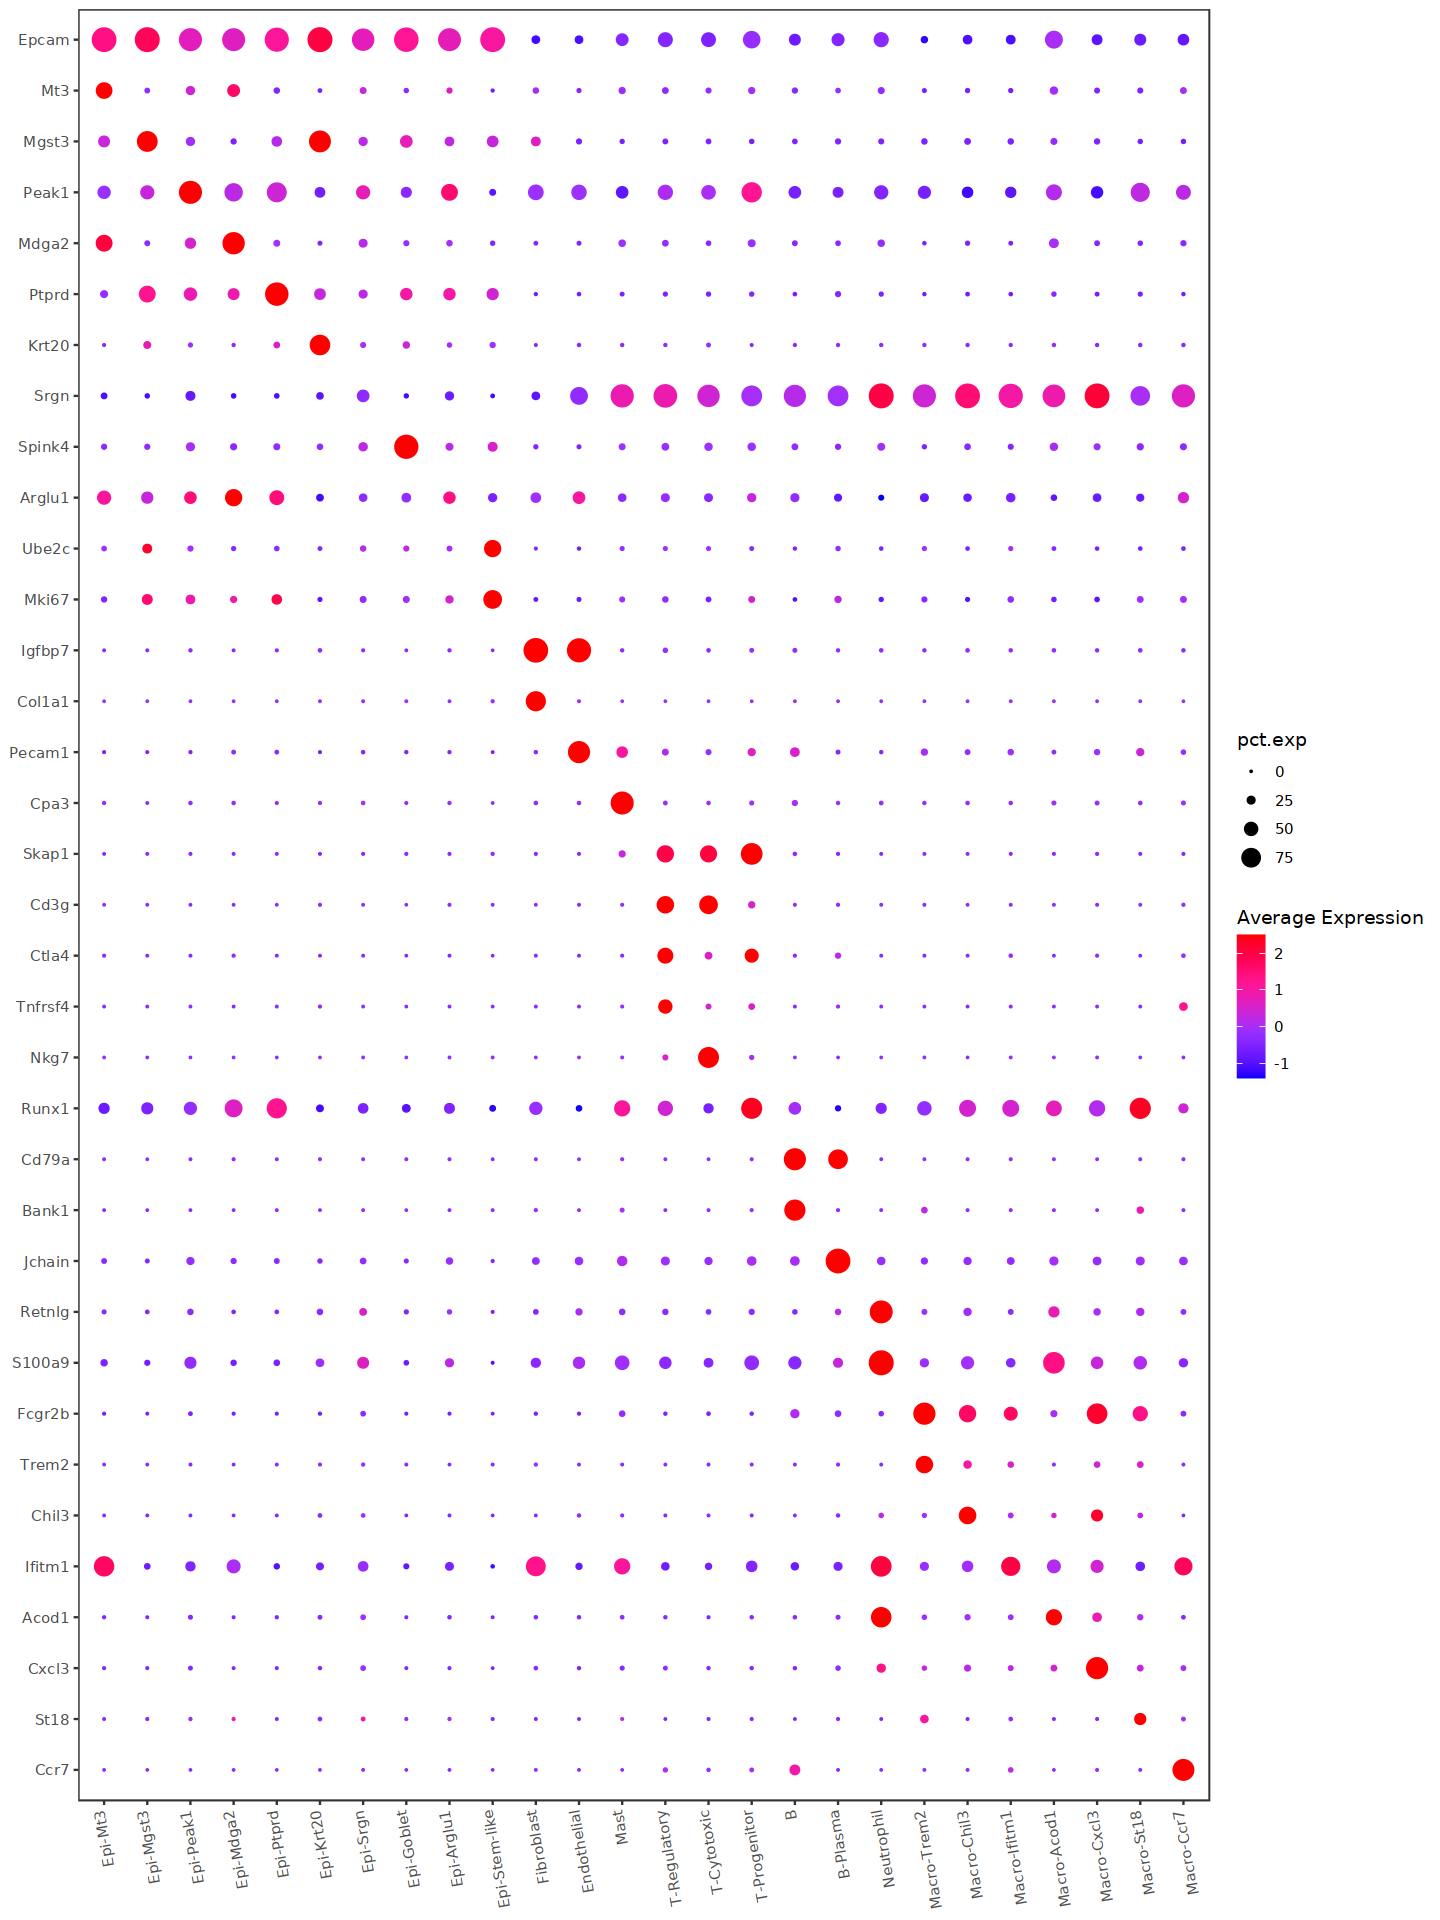

In [22]:
Idents(scdata)="fine"
FinebubblePlot=DotPlot(scdata, features = FineGene)+coord_flip()+
  theme_bw()+
  theme(panel.grid = element_blank(), axis.text.x=element_text(hjust = 1,vjust=0,angle = 100))+
  labs(x=NULL,y=NULL)+guides(size=guide_legend(order=3))+
  scale_color_gradientn(values = seq(0,1,0.2),colours = c("#0000FF", "#9B30FF", "#FF1493", "#FF0000"))
FinebubblePlot

In [24]:
ggsave(FinebubblePlot,filename = "results/plot/FinebubblePlot.pdf",width = 7,height = 7.5)

# cell type composition

## barplot

In [7]:
pctMatrix=table(scdata$fine,scdata$sampleID) %>% as.data.frame() %>%
             as_tibble()  %>% set_names(c("cellType","sampleID","num"))

In [8]:
table(pctMatrix$cellType)


      Epi-Mt3     Epi-Mgst3     Epi-Peak1     Epi-Mdga2     Epi-Ptprd 
           11            11            11            11            11 
    Epi-Krt20      Epi-Srgn    Epi-Goblet    Epi-Arglu1 Epi-Stem-like 
           11            11            11            11            11 
   Fibroblast   Endothelial          Mast  T-Regulatory   T-Cytotoxic 
           11            11            11            11            11 
 T-Progenitor             B      B-Plasma    Neutrophil   Macro-Trem2 
           11            11            11            11            11 
  Macro-Chil3  Macro-Ifitm1   Macro-Acod1   Macro-Cxcl3    Macro-St18 
           11            11            11            11            11 
   Macro-Ccr7 
           11 

In [44]:
pctMatrix$sampleID=factor(pctMatrix$sampleID,levels = rev(c('148_T1','148_T3','142_T5-4','132_T1','142_T2',
                                                        '18_T3','18_T4','17_T4','151_T4','WT2','WT1')))

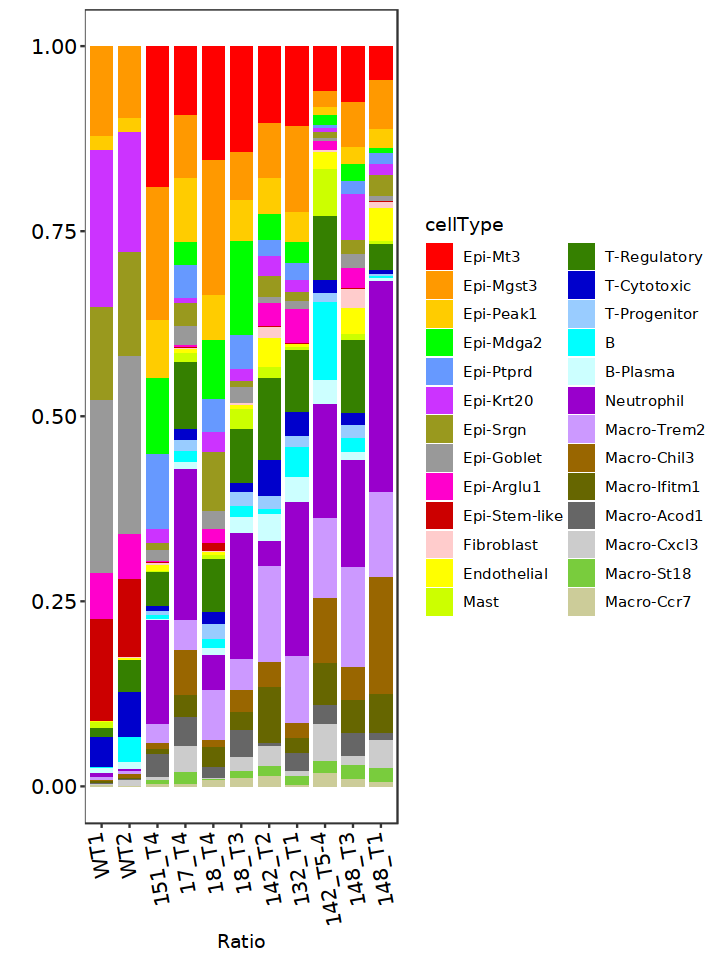

In [45]:
options(repr.plot.width=6,repr.plot.height=8)
pct.celltypePlot <- ggplot(data = pctMatrix, aes(x = num, y = sampleID, fill = cellType)) +
  geom_bar(stat = "identity", width=0.8,position="fill")+
  scale_fill_manual(values=fineColor) +
  theme_bw()+
  theme(panel.grid =element_blank()) +
  labs(x="",y="Ratio")+
  ####用来将y轴移动位置
  theme(axis.text.y = element_text(size=12, colour = "black"))+
  theme(axis.text.x = element_text(size=12, colour = "black"))+
  theme(axis.text.x=element_text(hjust = 1,vjust=0,angle = 100))+
  coord_flip()
pct.celltypePlot

In [46]:
ggsave(pct.celltypePlot,filename = "results/plot/pct.celltypePlotFine.pdf",width =6 ,height = 8)

# get filtered counts data and metadata

In [9]:
DefaultAssay(scdata)="RNA"
scdata=JoinLayers(scdata)

In [10]:
scdata

An object of class Seurat 
50442 features across 45620 samples within 2 assays 
Active assay: RNA (27738 features, 0 variable features)
 2 layers present: data, counts
 1 other assay present: SCT
 8 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, integrated.rpca, integrated.harmony, umap.cca, umap.rpca, umap.harmony

In [52]:
filteredCountsData=LayerData(scdata, assay = "RNA", layer = "counts")%>%as.data.frame()

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 9.4 GiB”


In [53]:
filteredCountsData[1:3,1:3]
dim(filteredCountsData)

WT_1.bcHTXJ WT_1.bcHGRE WT_1.bcHIFA
0610006L08Rik 0           0           0          
0610009B22Rik 0           2           0          
0610009E02Rik 0           0           0

[1] 27738 45620

In [56]:
saveRDS(filteredCountsData,"results/filteredCountsMatrix.rds")

In [57]:
scdata

An object of class Seurat 
50442 features across 45620 samples within 2 assays 
Active assay: RNA (27738 features, 0 variable features)
 2 layers present: data, counts
 1 other assay present: SCT
 8 dimensional reductions calculated: pca, umap.unintegrated, integrated.cca, integrated.rpca, integrated.harmony, umap.cca, umap.rpca, umap.harmony

In [58]:
Metadata=scdata@meta.data%>%select(sampleID,Phase,sampleType,harmony_cluster,main,fine)

In [60]:
UMAP=Embeddings(scdata, reduction = "umap.harmony")

In [61]:
identical(rownames(Metadata),rownames(UMAP))

[1] TRUE

In [62]:
metadata=cbind(UMAP,Metadata)

In [63]:
head(metadata)

umapharmony_1 umapharmony_2 sampleID Phase sampleType
WT_1.bcHTXJ  2.098463     11.915050     WT1      G1    normal    
WT_1.bcHGRE -2.963659      5.688989     WT1      G2M   normal    
WT_1.bcHIFA  2.224273     11.762798     WT1      G2M   normal    
WT_1.bcHFJN  2.247773     12.033408     WT1      G1    normal    
WT_1.bcGOTP  5.427313     -4.108789     WT1      S     normal    
WT_1.bcFBTL  1.870138     12.584858     WT1      G1    normal    
            harmony_cluster main       fine      
WT_1.bcHTXJ 10              Epithelial Epi-Krt20 
WT_1.bcHGRE 11              Epithelial Epi-Srgn  
WT_1.bcHIFA 10              Epithelial Epi-Krt20 
WT_1.bcHFJN 10              Epithelial Epi-Krt20 
WT_1.bcGOTP 0               Neutrophil Neutrophil
WT_1.bcFBTL 10              Epithelial Epi-Krt20

In [64]:
names(table(metadata$sampleType))

[1] "normal" "tumor"

In [65]:
saveRDS(metadata,"results/metadata.rds")

In [66]:
write.table(metadata,"/home/xiangwei/codes/metadata.csv",sep = ",")

In [ ]:
sessionInfo()